In [1]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE

import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
test_file = './test.csv'

In [4]:
train_file= './train.csv'

In [5]:
test_df = pd.read_csv(test_file)

In [6]:
train_df = pd.read_csv(train_file)

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [9]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [10]:
train_df['Id'] = train_df['Id'].astype('str')
train_df['Id'].dtype

dtype('O')

## Обзор количественных переменных

In [11]:
train_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_num_features.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


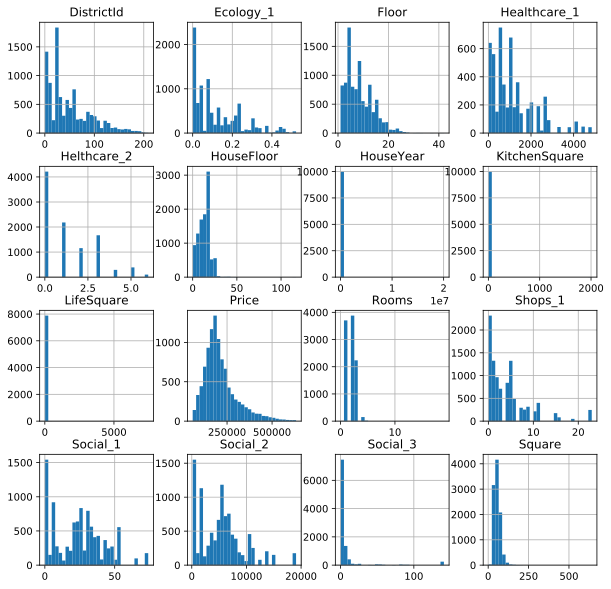

In [12]:
train_num_features.hist(figsize=(10,10), bins=30);

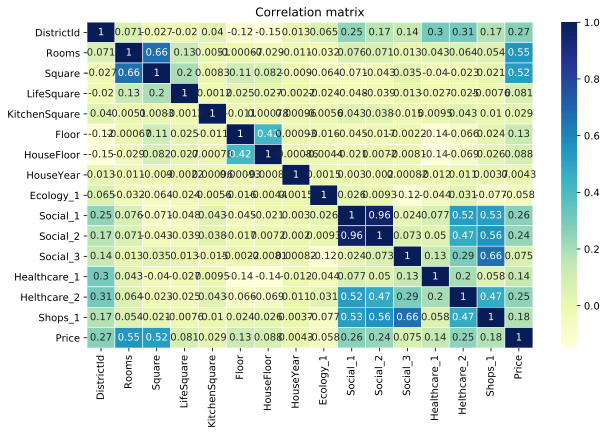

In [13]:
plt.figure(figsize = (10, 6))

sns.heatmap(train_num_features.corr(), annot=True, linewidths=.5, cmap='YlGnBu')

plt.title('Correlation matrix')
plt.show()

### Обработка пропусков

In [14]:
train_df.isna().sum(axis=0)

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [15]:
# Заменяем отсутствующие значения LifeSquare на средние
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['LifeSquare'].mean()

In [16]:
train_df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

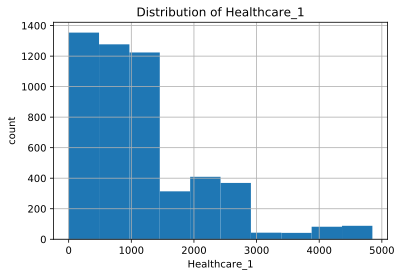

In [17]:
# Изучаем Healthcare_1
train_df['Healthcare_1'].hist()
plt.ylabel('count')
plt.xlabel('Healthcare_1')
plt.title('Distribution of Healthcare_1')
plt.show()

In [18]:
# Заменяем Healthcare_1 на среднее
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].mean()

### Поиск и обработка выбросов

In [19]:
# Дома без комнат
id_for_test = train_df.loc[train_df['Rooms'] <= 0]['Id']
train_df[train_df['Rooms'] <= 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,1142.90446,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,1142.90446,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,37.199645,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,98129.976788
3911,770,28,0.0,49.483501,37.199645,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.00000,1,0,B,217009.338463
4366,456,6,0.0,81.491446,37.199645,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.00000,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,1142.90446,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,1142.90446,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,219281.918007


In [20]:
# Меняем на mode()
train_df.loc[train_df['Rooms'] <= 0, 'Rooms'] = train_df['Rooms'].mode()[0]

In [21]:
# Прверяем
train_df.loc[train_df['Id'].isin(id_for_test)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,2.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,1142.90446,0,0,B,268394.744389
1981,7917,27,2.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,1142.90446,0,1,B,302211.260887
2269,7317,27,2.0,41.790881,37.199645,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,98129.976788
3911,770,28,2.0,49.483501,37.199645,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.00000,1,0,B,217009.338463
4366,456,6,2.0,81.491446,37.199645,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.00000,0,0,B,212864.799112
4853,3224,27,2.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,1142.90446,0,0,B,126596.941798
6149,3159,88,2.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,1142.90446,3,9,B,158998.110646
8834,9443,27,2.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,219281.918007


In [22]:
# Жилая площадь больше общей
id_for_test = train_df.loc[train_df['Square'] < train_df['LifeSquare']]['Id']
train_df.loc[train_df['Square'] < train_df['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,1142.90446,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.00000,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,1142.90446,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,1142.90446,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,B,B,2,629,1,1142.90446,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,1142.90446,0,0,B,234194.837047
9902,14001,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.00000,2,5,B,381937.404161
9908,3171,62,1.0,35.873961,37.199645,0.0,25,0.0,1977,0.072158,B,B,2,629,1,1142.90446,0,0,A,134379.130962
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,1142.90446,1,4,B,528560.506016


In [23]:
# Меняем местами столбцы, где жилая площадь больше общей
sq = train_df.loc[train_df['Square'] < train_df['LifeSquare'], ['LifeSquare', 'Square']]
sq.rename(columns={'LifeSquare': 'Square', 'Square': 'LifeSquare'}, inplace=True)
train_df.loc[train_df['Square'] < train_df['LifeSquare'], ['Square', 'LifeSquare']] = sq

In [24]:
# Проверяем
train_df.loc[train_df['Id'].isin(id_for_test)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,43.967759,42.530043,1.0,3,9.0,2014,0.034656,B,B,0,168,0,1142.90446,0,0,B,95338.198549
44,10521,38,3.0,106.340403,104.211396,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.00000,0,7,B,435462.048070
52,2301,1,2.0,65.224603,61.400054,0.0,17,22.0,2016,0.007122,B,B,1,264,0,1142.90446,0,1,B,199215.452229
123,8753,25,3.0,89.803753,85.952306,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,1142.90446,1,11,B,309688.592681
153,9870,62,1.0,53.491301,51.831473,1.0,5,1.0,2015,0.072158,B,B,2,629,1,1142.90446,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,2737,27,3.0,125.806981,123.430072,123.0,5,10.0,2015,0.017647,B,B,2,469,0,1142.90446,0,0,B,234194.837047
9902,14001,73,1.0,44.267551,44.098768,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.00000,2,5,B,381937.404161
9908,3171,62,1.0,37.199645,35.873961,0.0,25,0.0,1977,0.072158,B,B,2,629,1,1142.90446,0,0,A,134379.130962
9910,16568,27,4.0,201.627361,200.334539,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,1142.90446,1,4,B,528560.506016


In [25]:
# Общая площадь меньше кухни
id_for_test = train_df.loc[train_df['Square'] < train_df['KitchenSquare']]['Id']
train_df[train_df['Square'] < train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,1142.90446,0,0,A,108337.484207
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,1142.90446,1,0,B,160488.033165
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,1142.90446,0,0,B,99079.960518
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.00000,6,6,B,105539.556275


In [26]:
# Заменим площадь кухни на остаток от общей-жилой
train_df.loc[train_df['Square'] < train_df['KitchenSquare'], 'KitchenSquare'] = train_df.loc[train_df['Square'] < train_df['KitchenSquare'], 'Square']-train_df.loc[train_df['Square'] < train_df['KitchenSquare'], 'LifeSquare']

In [27]:
# Проверяем
train_df.loc[train_df['Id'].isin(id_for_test)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,0.652759,4,1.0,2014,0.072158,B,B,2,629,1,1142.90446,0,0,A,108337.484207
5149,13703,42,1.0,38.071692,19.723548,18.348144,9,10.0,2006,0.158249,B,B,21,5731,0,1142.90446,1,0,B,160488.033165
7088,6569,27,1.0,38.220258,18.716856,19.503403,4,17.0,2018,0.011654,B,B,4,915,0,1142.90446,0,0,B,99079.960518
8584,14679,81,1.0,32.276663,19.278394,12.998269,6,1.0,1977,0.006076,B,B,30,5285,0,645.00000,6,6,B,105539.556275


In [28]:
# Ищем дома с <=0 этажей
id_for_test = train_df[train_df['HouseFloor'] <= 0]['Id']
train_df[train_df['HouseFloor'] <= 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,37.199645,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,1142.90446,0,2,B,221244.156664
23,6641,54,3.0,118.907612,37.199645,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.00000,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,1142.90446,0,0,A,337299.867936
39,9371,23,2.0,60.503248,37.199645,0.0,16,0.0,1977,0.034656,B,B,0,168,0,1142.90446,0,0,B,229778.057902
44,10521,38,3.0,106.340403,104.211396,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.00000,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.0,48.307844,46.072913,0.0,4,0.0,1977,0.000078,B,B,22,6398,141,1046.00000,3,23,B,161403.094034
9769,9384,59,3.0,98.607328,37.199645,0.0,14,0.0,1977,0.019509,B,B,37,7687,11,176.00000,5,5,B,492700.257473
9878,11441,62,2.0,72.453232,71.985335,0.0,5,0.0,1977,0.072158,B,B,2,629,1,1142.90446,0,0,A,158841.624543
9908,3171,62,1.0,37.199645,35.873961,0.0,25,0.0,1977,0.072158,B,B,2,629,1,1142.90446,0,0,A,134379.130962


In [29]:
# Предположим, что квартиры на последних этажах
train_df.loc[train_df['HouseFloor'] <= 0, 'HouseFloor'] = train_df.loc[train_df['HouseFloor'] <= 0, 'Floor']

In [30]:
# Этаж квартиры больше этажей дома
id_for_test = train_df.loc[train_df['Floor'] > train_df['HouseFloor']]['Id']
train_df.loc[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,1142.90446,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,1142.90446,0,0,B,117000.381287
21,11935,27,2.0,64.711835,37.199645,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,127200.026511
35,6486,200,3.0,85.280389,58.447967,9.0,6,5.0,1960,0.000000,B,B,33,7425,1,1142.90446,2,5,B,402871.916317
51,10103,94,1.0,35.280894,23.354176,6.0,11,9.0,1971,0.282798,B,B,33,8667,2,1142.90446,0,6,B,148862.210174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,750.00000,2,5,B,226434.880156
9985,16159,27,1.0,38.968338,37.199645,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,95529.569405
9989,4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,1142.90446,1,4,B,441108.911237
9991,11553,3,3.0,101.622794,51.628780,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,1937.00000,3,2,B,212883.501504


In [31]:
# Приведем HouseFloor к int64 и поменяем местами этажи квартир и этажность домов
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int64')
swap = train_df.loc[train_df['HouseFloor'] < train_df['Floor'], ['Floor', 'HouseFloor']]
swap.rename(columns={'HouseFloor': 'Floor', 'Floor': 'HouseFloor'}, inplace=True)
train_df.loc[train_df['HouseFloor'] < train_df['Floor'], ['Floor', 'HouseFloor']] = swap

In [32]:
# Проверяем
train_df.loc[train_df['Id'].isin(id_for_test)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14,10953,27,1.0,53.769097,52.408027,1.0,4,5,1977,0.072158,B,B,2,629,1,1142.90446,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,5,6,1983,0.051815,B,B,5,1227,0,1142.90446,0,0,B,117000.381287
21,11935,27,2.0,64.711835,37.199645,1.0,1,15,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,127200.026511
35,6486,200,3.0,85.280389,58.447967,9.0,5,6,1960,0.000000,B,B,33,7425,1,1142.90446,2,5,B,402871.916317
51,10103,94,1.0,35.280894,23.354176,6.0,9,11,1971,0.282798,B,B,33,8667,2,1142.90446,0,6,B,148862.210174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074977,47.633428,6.0,9,11,1983,0.371149,B,B,34,7065,1,750.00000,2,5,B,226434.880156
9985,16159,27,1.0,38.968338,37.199645,1.0,1,10,1977,0.211401,B,B,9,1892,0,1142.90446,0,1,B,95529.569405
9989,4145,96,3.0,90.055233,47.860231,11.0,24,26,2005,0.041116,B,B,53,14892,4,1142.90446,1,4,B,441108.911237
9991,11553,3,3.0,101.622794,51.628780,12.0,17,18,2000,0.265089,B,B,37,5288,0,1937.00000,3,2,B,212883.501504


In [33]:
# Проверка года постройки
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [34]:
train_df.loc[(train_df['HouseYear'] < 1900) | (train_df['HouseYear'] > 2020)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [35]:
train_df.loc[train_df['Id'] == 10814, 'HouseYear'] = 2005
train_df.loc[train_df['Id'] == 11607, 'HouseYear'] = 1968

In [36]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,1142.90446,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.00000,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.00000,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.00000,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.00000,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,5,6,1968,0.135650,B,B,46,7960,6,350.00000,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,1142.90446,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,37.199645,1.0,12,16,2015,0.072158,B,B,2,629,1,1142.90446,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5,1961,0.307467,B,A,30,5048,9,325.00000,2,5,B,181595.339808


### Подготовка 

In [37]:
X_train = train_df.drop(['Id','Price'], axis=1)

In [38]:
X_train = pd.get_dummies(X_train)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  int64  
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Social_1       10000 non-null  int64  
 10  Social_2       10000 non-null  int64  
 11  Social_3       10000 non-null  int64  
 12  Healthcare_1   10000 non-null  float64
 13  Helthcare_2    10000 non-null  int64  
 14  Shops_1        10000 non-null  int64  
 15  Ecology_2_A    10000 non-null  uint8  
 16  Ecology_2_B    10000 non-null  uint8  
 17  Ecology_3_A    10000 non-null  uint8  
 18  Ecology

In [39]:
y_train = train_df['Price']
y_train

0       184966.930730
1       300009.450063
2       220925.908524
3       175616.227217
4       150226.531644
            ...      
9995    196684.316040
9996    189050.289571
9997    159143.805370
9998    181595.339808
9999    218714.077615
Name: Price, Length: 10000, dtype: float64

### Обработка test_df

In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [41]:
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['LifeSquare'].mean()

In [42]:
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].mean()

In [43]:
test_ids = test_df['Id']

In [44]:
test_df.drop('Id', axis=1, inplace=True)

In [45]:
test_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,1142.90446,0,0,B
1,74,2.0,69.263183,36.254713,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,1142.90446,0,2,B
2,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.00000,5,5,B
3,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,1142.90446,3,3,B
4,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,1142.90446,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,1142.90446,1,1,B
4996,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,1142.90446,0,1,B
4997,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,1142.90446,5,15,B
4998,62,2.0,81.305222,36.254713,0.0,4,0.0,1977,0.072158,B,B,2,629,1,1142.90446,0,0,A


In [46]:
X_test = pd.get_dummies(test_df)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Social_1       5000 non-null   int64  
 10  Social_2       5000 non-null   int64  
 11  Social_3       5000 non-null   int64  
 12  Healthcare_1   5000 non-null   float64
 13  Helthcare_2    5000 non-null   int64  
 14  Shops_1        5000 non-null   int64  
 15  Ecology_2_A    5000 non-null   uint8  
 16  Ecology_2_B    5000 non-null   uint8  
 17  Ecology_3_A    5000 non-null   uint8  
 18  Ecology_

### Стандартизация признаков

In [47]:
scaler = StandardScaler()

In [48]:
features_for_scale = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
features_for_scale

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [49]:
# Стандартизируем train
X_train_scaled = scaler.fit_transform(X_train[features_for_scale])
X_train_scaled

array([[-0.35334758,  0.12879439, -0.12004967, ...,  0.        ,
        -0.8834798 ,  1.40835595],
       [-0.21568684,  1.32244026,  0.10897234, ..., -1.22561103,
        -0.2139233 ,  2.44870045],
       [ 0.05963463,  0.12879439, -0.15929721, ..., -1.24054253,
        -0.2139233 , -0.25619523],
       ...,
       [-0.53689523, -1.06485148, -0.12060021, ...,  0.        ,
        -0.8834798 , -0.88040193],
       [ 0.56439067,  0.12879439, -0.17670332, ..., -1.11023123,
         0.4556332 ,  0.15994256],
       [ 1.78039385, -1.06485148, -0.24056212, ..., -1.51066701,
         0.4556332 ,  0.78414926]])

In [50]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_for_scale)

In [51]:
X_train[features_for_scale] = X_train_scaled
X_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,-0.353348,0.128794,-0.120050,-0.395694,0.026733,-0.180418,-0.727915,-0.010081,-0.250529,0.474169,...,-0.127533,0.000000,-0.883480,1.408356,0,1,0,1,0,1
1,-0.215687,1.322440,0.108972,0.220434,0.420875,-0.180418,-0.727915,-0.010036,-0.998053,1.215681,...,-0.295384,-1.225611,-0.213923,2.448700,0,1,0,1,0,1
2,0.059635,0.128794,-0.159297,-0.409933,-1.155694,0.010865,-0.235604,-0.010086,-0.581588,0.531208,...,-0.337347,-1.240543,-0.213923,-0.256195,0,1,0,1,0,1
3,0.174352,0.128794,-0.050557,0.957105,0.617946,0.010865,0.584915,-0.010041,2.680470,-0.096225,...,-0.211458,-0.079957,-0.883480,0.159943,0,1,0,1,0,1
4,1.115034,-1.064851,-0.227850,-0.724854,0.223804,0.584713,-0.235604,-0.010046,-0.894969,0.588247,...,-0.295384,1.269308,0.455633,-0.048126,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.422178,0.128794,-0.088738,-0.335662,-0.170338,-0.562983,-1.220226,-0.010086,0.141089,1.215681,...,-0.085570,-1.076296,1.125190,1.408356,0,1,0,1,0,1
9996,-0.743386,-1.064851,-0.203627,-0.912882,0.617946,0.967278,-0.071500,-0.009926,-0.998641,0.303050,...,-0.337347,0.000000,-0.883480,0.159943,0,1,0,1,1,0
9997,-0.536895,-1.064851,-0.120600,0.054889,-0.958623,0.775996,0.420811,-0.009852,-0.392373,-1.294053,...,-0.295384,0.000000,-0.883480,-0.880402,0,1,0,1,1,0
9998,0.564391,0.128794,-0.176703,-0.140257,0.420875,-1.328114,-1.384330,-0.010121,1.584694,0.303050,...,0.040318,-1.110231,0.455633,0.159943,0,1,1,0,0,1


In [52]:
# Стандартизируем test
X_test_scaled = scaler.transform(X_test[features_for_scale])
X_test_scaled

array([[ 1.74351913e-01,  1.28794389e-01, -9.54542719e-02, ...,
        -1.15739689e-13, -8.83479798e-01, -8.80401930e-01],
       [ 5.41447213e-01,  1.28794389e-01,  1.55282960e-01, ...,
        -1.15739689e-13, -8.83479798e-01, -4.64264133e-01],
       [ 3.20288814e+00, -1.06485148e+00, -5.64891993e-01, ...,
         4.83114985e+00,  2.46430269e+00,  1.59942562e-01],
       ...,
       [-8.81047076e-01,  1.32244026e+00,  2.66274363e-01, ...,
        -1.15739689e-13,  2.46430269e+00,  2.24063155e+00],
       [ 2.66125738e-01,  1.28794389e-01,  3.11077763e-01, ...,
        -1.15739689e-13, -8.83479798e-01, -8.80401930e-01],
       [-4.68064863e-01,  1.28794389e-01,  4.26291269e-02, ...,
        -1.31539028e-01,  1.12518969e+00,  3.90518273e+00]])

In [53]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features_for_scale)
X_test_scaled

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,0.174352,0.128794,-0.095454,-1.639204e-01,0.026733,-0.371700,0.092604,-0.010066,1.607652,-0.780698,-0.649967,-0.295384,-1.157397e-13,-0.883480,-0.880402
1,0.541447,0.128794,0.155283,1.320769e-14,-0.958623,-0.371700,-2.040745,-0.010041,-0.361948,-1.065895,-0.977177,-0.211458,-1.157397e-13,-0.883480,-0.464264
2,3.202888,-1.064851,-0.564892,-1.179563e+00,1.209159,-1.136831,-1.384330,-0.010380,-0.998641,0.303050,0.545561,3.313409,4.831150e+00,2.464303,0.159943
3,-0.078026,0.128794,0.204231,9.111765e-01,0.617946,2.688822,1.405433,-0.009892,-0.142708,-0.096225,-0.191973,-0.211458,-1.157397e-13,1.125190,-0.256195
4,-0.536895,-1.064851,-0.125929,4.143337e-01,-0.958623,1.732409,0.584915,-0.009842,-0.392373,-1.294053,-1.178844,-0.295384,-1.157397e-13,-0.883480,-0.880402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.903991,1.322440,0.127735,8.454764e-01,0.026733,-0.562983,-0.727915,-0.010061,-0.997215,0.645287,0.159697,-0.337347,-1.157397e-13,-0.213923,-0.672333
4996,-1.133425,-1.064851,-0.220744,-8.392358e-01,0.815017,0.775996,0.584915,-0.009842,-0.938799,-1.351093,-1.269944,-0.337347,-1.157397e-13,-0.883480,-0.672333
4997,-0.881047,1.322440,0.266274,6.986779e-01,0.617946,2.880105,1.405433,-0.009981,-0.235747,2.812784,3.427056,-0.253421,-1.157397e-13,2.464303,2.240632
4998,0.266126,0.128794,0.311078,1.320769e-14,-1.155694,-0.754266,-2.204848,-0.010041,-0.392373,-1.294053,-1.178844,-0.295384,-1.157397e-13,-0.883480,-0.880402


In [54]:
X_test[features_for_scale] = X_test_scaled
X_test

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0.174352,0.128794,-0.095454,-1.639204e-01,0.026733,-0.371700,0.092604,-0.010066,1.607652,-0.780698,...,-0.295384,-1.157397e-13,-0.883480,-0.880402,0,1,0,1,0,1
1,0.541447,0.128794,0.155283,1.320769e-14,-0.958623,-0.371700,-2.040745,-0.010041,-0.361948,-1.065895,...,-0.211458,-1.157397e-13,-0.883480,-0.464264,0,1,0,1,0,1
2,3.202888,-1.064851,-0.564892,-1.179563e+00,1.209159,-1.136831,-1.384330,-0.010380,-0.998641,0.303050,...,3.313409,4.831150e+00,2.464303,0.159943,0,1,0,1,0,1
3,-0.078026,0.128794,0.204231,9.111765e-01,0.617946,2.688822,1.405433,-0.009892,-0.142708,-0.096225,...,-0.211458,-1.157397e-13,1.125190,-0.256195,0,1,0,1,0,1
4,-0.536895,-1.064851,-0.125929,4.143337e-01,-0.958623,1.732409,0.584915,-0.009842,-0.392373,-1.294053,...,-0.295384,-1.157397e-13,-0.883480,-0.880402,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.903991,1.322440,0.127735,8.454764e-01,0.026733,-0.562983,-0.727915,-0.010061,-0.997215,0.645287,...,-0.337347,-1.157397e-13,-0.213923,-0.672333,0,1,0,1,0,1
4996,-1.133425,-1.064851,-0.220744,-8.392358e-01,0.815017,0.775996,0.584915,-0.009842,-0.938799,-1.351093,...,-0.337347,-1.157397e-13,-0.883480,-0.672333,0,1,0,1,0,1
4997,-0.881047,1.322440,0.266274,6.986779e-01,0.617946,2.880105,1.405433,-0.009981,-0.235747,2.812784,...,-0.253421,-1.157397e-13,2.464303,2.240632,0,1,0,1,0,1
4998,0.266126,0.128794,0.311078,1.320769e-14,-1.155694,-0.754266,-2.204848,-0.010041,-0.392373,-1.294053,...,-0.295384,-1.157397e-13,-0.883480,-0.880402,0,1,0,1,1,0


## Построение модели

In [55]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))

In [56]:
# Параметры для RFR получены с помощью GridSearchCV
rf = RandomForestRegressor(n_estimators=2000, max_depth=18, random_state=100)

In [61]:
rf.fit(X_train.drop('Healthcare_1', axis=1), y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=18, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [62]:
y_train_pred = rf.predict(X_train.drop('Healthcare_1', axis=1))
evaluate_preds(y_train.values.flatten(), y_train_pred.flatten())

R2:	0.956
MAE:	12312.101
MSE:	378533597.474


In [63]:
y_test_pred = rf.predict(X_test.drop('Healthcare_1', axis=1))
submission = pd.DataFrame()
submission['Id'] = test_ids
submission['Price'] = y_test_pred
submission

,Id,Price
0,725,162456.572801
1,15856,219524.427873
2,5480,205612.865117
3,15664,345135.803842
4,14275,146640.837921
...,...,...
4995,8180,249771.794935
4996,4695,132813.178284
4997,5783,334928.576100
4998,4780,201264.528225


In [64]:
submission.to_csv('./DMaltsev_predictions.csv', index=False)